# FastFlow Anomaly Detection
This notebook trains and evaluates a FastFlow model for anomaly detection.  Design tenants include high visibility on image data and model performance.  The goal is to provide a comprehensive framework for developing anomaly detection models, while explaining the code along the way.

### Contents
1. Setup Variables
2. Setup MLFLow Logging
3. Data Augmentations
4. Data Preparation
5. What is a DataLoader and what is a DataModule?
6. Training the Model
7. Model Evaluation
8. Visualize a Single Prediction
9. Predict and Visualize the Dataset
10. Data Validation
11. Save the Model

## Setup Variables ⚙️

<small>[Back to Top](#contents)</small>

In [1]:
import os
import logging
import argparse
from dotenv import load_dotenv
from pytorch_lightning import seed_everything

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)

load_dotenv("../../secrets.env")
load_dotenv("../../config.env")

ENVIRONMENT = os.getenv("ENVIRONMENT", "DEVELOPMENT")

logging.info(f"Running in {ENVIRONMENT} environment")

if ENVIRONMENT == "PRODUCTION":
    MLFLOW_URI = os.getenv('MLFLOW_URI')
else:
    MLFLOW_URI = "http://mlflow-mlflow"

if MLFLOW_URI is None:
    logging.warning("MLFLOW_URI not found in environment variables. MLFlow logging will not be enabled.")

parser = argparse.ArgumentParser()
parser.add_argument("--bucket_name", type=str, default="mvtechad", help="S3 bucket name")
parser.add_argument("--category", type=str, default="XRFC-PCB-Quality", help="Dataset category (top-level directory in bucket)")
#parser.add_argument("--category", type=str, default="bottle", help="Dataset category (top-level directory in bucket)")
parser.add_argument("--cache_directory", type=str, default="s3cache", help="Cache directory (local path, will be created if not exists)")
parser.add_argument("--max_epochs", type=int, default=100, help="Maximum number of epochs for training")
args, _ = parser.parse_known_args()  # allows notebook execution

bucket_name = args.bucket_name
category = args.category
cache_directory = args.cache_directory
max_epochs = args.max_epochs

logging.info(f"Using bucket: {bucket_name}, category: {category}, cache directory: {cache_directory}")

# Set seed for reproducibility
seed_everything(42)

2025-09-14 12:36:27,292 - root - INFO - Running in DEVELOPMENT environment
2025-09-14 12:36:27,293 - root - INFO - Using bucket: mvtechad, category: XRFC-PCB-Quality, cache directory: s3cache
Seed set to 42


42

## Setup MLFLow Logging 📊
MLFlow lets us log model parameters, metrics, and artifacts, making it easier to track experiments and reproduce results.  Additionally, it provides a centralized repository for managing and comparing different model versions.
<small>[Back to Top](#contents)</small>

In [2]:
# Setup MLFlow Logging

if MLFLOW_URI is not None:
    logging.info(f"MLFLOW_URI found: {MLFLOW_URI}")
    import mlflow

experiment_name = f"{category}_fastflow_experiment"
mlflow.set_tracking_uri(MLFLOW_URI)
mlflow.set_experiment(experiment_name)

2025-09-14 12:36:27,303 - root - INFO - MLFLOW_URI found: http://mlflow-mlflow


<Experiment: artifact_location='mlflow-artifacts:/3', creation_time=1756264677060, experiment_id='3', last_update_time=1756264677060, lifecycle_stage='active', name='XRFC-PCB-Quality_fastflow_experiment', tags={}>

## Data Augmentations 🏋️

Data augmentation is a technique used to increase the diversity of your training dataset by applying various transformations to the existing data. This helps improve the model's generalization and robustness by exposing it to different variations of the input data, especially for smaller datasets.

Here is ChatGPT's summary of the Anomalib documentation on the subject:

- Model-specific transforms (e.g., resizing, normalization) are tightly coupled to the model architecture and should be set via the model's PreProcessor or configure_pre_processor method. These transforms are included in the exported model graph (ONNX/OpenVINO) and always applied during inference.
- Data augmentations (e.g., flips, rotations, brightness/contrast, noise) are for dataset enrichment and should be passed to the datamodule as train_augmentations, val_augmentations, or test_augmentations. These are not included in the exported model and are only applied during training.
- Do not mix: Do not add normalization or resizing to augmentations—these must be in the model-specific transforms. Likewise, do not add random augmentations to the model-specific transforms, as they will be applied during inference and validation, which is undesirable.
- Torchvision v2 API is recommended for augmentations in Anomalib (not Albumentations).
- Pitfalls: If you add normalization or resizing to augmentations, you may get double normalization or unexpected image sizes. Always use the correct transform for the correct purpose.

Recommended usage for FastFlow:

- Use Torchvision v2 transforms for augmentations in the datamodule.
- Use the model's default preprocessor for resizing and normalization.

In [3]:
import torch
from torchvision.transforms import v2


augmentations = v2.Compose([
    # v2.RandomHorizontalFlip(p=0.5),
    # v2.RandomVerticalFlip(p=0.2),
    #v2.RandomRotation(degrees=2),  # always applies
    v2.GaussianBlur(kernel_size=(3, 5), sigma=(0.1, 2.0)),
    v2.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1), # always applies
    v2.RandomGrayscale(p=0.05),
    v2.RandomApply([v2.RandomAdjustSharpness(sharpness_factor=2)], p=0.3),
])

## Data Preparation ⬇️

We'll use our s3data library to download/cache the data from our S3 bucket. This module expects a directory structure similar to the MVTechAD dataset. Then we'll use the anomalib Folder datamodule to hold our dataset.

<small>[Back to Top](#contents)</small>

In [4]:
from s3dataset import s3data
from anomalib.data import Folder
import os

s3data.set_aws_config(
    access_key_id=os.getenv('AWS_ACCESS_KEY_ID'),
    secret_access_key=os.getenv('AWS_SECRET_ACCESS_KEY'),
    region_name=os.getenv('AWS_REGION_NAME')
)

def count_images(directory):
    image_exts = ('.png', '.jpg', '.jpeg', '.bmp', '.tiff')
    count = 0
    for root, _, files in os.walk(directory):
        count += sum(f.lower().endswith(image_exts) for f in files)
    return count

images, class_names, labels, tags = s3data.get_dataset(bucket_name=bucket_name, prefix=category, limit=1000, cache_dir=cache_directory)

test_dir = os.path.join(cache_directory, category, 'test')
print(f"Test directory: {test_dir} with total count: {count_images(test_dir)}")

mask_dir = os.path.join(cache_directory, category, 'ground_truth')
print(f"Mask directory: {mask_dir} with total count: {count_images(mask_dir)}")

train_dir = os.path.join(cache_directory, category, 'train', 'good') # unsupervised training (no labels...only good images)
print(f"Train directory: {train_dir} with total count: {count_images(train_dir)}")

if os.path.exists(test_dir):
    test_data_available = True
    normal_test_dir = os.path.join('test', 'good') if os.path.exists(os.path.join(test_dir, 'good')) else None

    abnormal_dirs = [
        os.path.join('test', d)
        for d in os.listdir(test_dir)
        if os.path.isdir(os.path.join(test_dir, d)) and d != 'good'
    ]
    print(f"Found abnormal test directories: {abnormal_dirs} with total count: {count_images(test_dir)}")

    mask_dirs = [
        os.path.join('ground_truth', d)
        for d in os.listdir(mask_dir)
        if os.path.isdir(os.path.join(mask_dir, d))
    ]

    print(f"Found mask directories: {mask_dirs} with total count: {count_images(mask_dir)}")
else:
    logging.warning("No test directories found.")
    test_data_available = False
    normal_test_dir = None
    abnormal_dirs = None
    mask_dirs = None

datamodule = Folder(
    name=category,
    root=os.path.join(cache_directory, category),
    normal_dir=os.path.join('train', 'good'), 
    mask_dir=mask_dirs,
    normal_test_dir=normal_test_dir,
    abnormal_dir=abnormal_dirs,
    train_augmentations=augmentations,  # <-- Apply augmentation to training data
    num_workers=0
)

print("Preparing data...")
datamodule.prepare_data()

print(f"Setting up '{datamodule.name}' datasets...")
datamodule.setup()

Fetching dataset from S3 bucket: mvtechad
Downloaded: 0 Cached: 43 Ignored: 0

2025-09-14 12:36:29,369 - anomalib.data.datamodules.base.image - INFO - No normal test images found. Sampling from training set using ratio of 0.20



Test directory: s3cache\XRFC-PCB-Quality\test with total count: 4
Mask directory: s3cache\XRFC-PCB-Quality\ground_truth with total count: 4
Train directory: s3cache\XRFC-PCB-Quality\train\good with total count: 35
Found abnormal test directories: ['test\\anomaly'] with total count: 4
Found mask directories: ['ground_truth\\anomaly'] with total count: 4
Preparing data...
Setting up 'XRFC-PCB-Quality' datasets...


## Expand Dataset with Augmentations 🐇🐇🐇

In [5]:
class AugmentationMultiplier(torch.utils.data.Dataset):
    def __init__(self, original_dataset, augmentations, copies=3):
        """
        Wrapper dataset that returns multiple augmented versions of each sample
        
        Args:
            original_dataset: The base dataset
            augmentations: Transformations to apply
            copies: Number of augmented copies to create per original image
        """
        self.dataset = original_dataset
        self.augmentations = augmentations
        self.copies = copies
        
    def __len__(self):
        return len(self.dataset) * self.copies
        
    def __getitem__(self, idx):
        # Get original sample
        original_idx = idx // self.copies
        sample = self.dataset[original_idx]
        
        # If not the first copy, apply augmentation
        if idx % self.copies != 0:
            # Handle both tensor images and sample objects
            if isinstance(sample, torch.Tensor):
                sample = self.augmentations(sample)
            elif hasattr(sample, 'image'):
                # For anomalib samples
                augmented = self.augmentations(sample.image)
                if isinstance(augmented, tuple):
                    sample.image = augmented[0]
                else:
                    sample.image = augmented
                    
        return sample
    
    @property
    def collate_fn(self):
        return self.dataset.collate_fn
    

In [6]:
# Increase dataset size with augmentations

print(f"Original training dataset size: {len(datamodule.train_data)}")
augmentation_copies = 10  # Number of copies to create

# Replace the train_data with our augmented version
datamodule.train_data = AugmentationMultiplier(
    datamodule.train_data, 
    augmentations,
    copies=augmentation_copies
)

print(f"Augmented training dataset size: {len(datamodule.train_data)}")


Original training dataset size: 28
Augmented training dataset size: 280


### What is a DataLoader and what is a DataModule? 🤔

**DataLoader:**

- A PyTorch `DataLoader` is a utility that loads data from a dataset and serves it in batches to your model during training or inference.
- It handles shuffling, batching, and parallel loading using multiple workers.
- Example: `DataLoader(dataset, batch_size=32, shuffle=True)`

**DataModule:**

- A `DataModule` (from PyTorch Lightning or similar frameworks) is a higher-level abstraction that organizes all data-related steps for a project.
- It encapsulates dataset preparation, setup, and provides ready-to-use DataLoaders for training, validation, and testing.
- This helps keep data logic separate from model logic and makes experiments more reproducible.
- Example: `datamodule.train_dataloader()` returns a DataLoader for training data.

<small>[Back to Top](#contents)</small>

In [7]:
# This cell is for exploring the dataset only, and has no impact on training or the rest of the notebook

print("Dataset sizes:")
print(f"Training dataset size: {len(datamodule.train_data)}")
print(f"Test dataset size: {len(datamodule.test_data)}")

datamodule_attribs = (attr for attr in dir(datamodule) if not attr.startswith("_"))
print("\nDatamodule attributes:")
print(list(datamodule_attribs))

# Get dataloaders
train_loader = datamodule.train_dataloader()
test_loader = datamodule.test_dataloader()

print("\nDataLoader batch sizes:")
print(f"Training batch size: {train_loader.batch_size}")
print(f"Test batch size: {test_loader.batch_size}")

# Get a item or batch
data_item = next(iter(train_loader))
print(f"\nThe dataloader provided the type {type(data_item)}")
data_item_attribs = (attr for attr in dir(data_item) if not attr.startswith("_"))
print(f"Data item attributes: {list(data_item_attribs)}")

Dataset sizes:
Training dataset size: 280
Test dataset size: 6

Datamodule attributes:
['CHECKPOINT_HYPER_PARAMS_KEY', 'CHECKPOINT_HYPER_PARAMS_NAME', 'CHECKPOINT_HYPER_PARAMS_TYPE', 'abnormal_dir', 'allow_zero_length_dataloader_with_multiple_devices', 'category', 'eval_batch_size', 'extensions', 'external_collate_fn', 'from_config', 'from_datasets', 'hparams', 'hparams_initial', 'load_from_checkpoint', 'load_state_dict', 'mask_dir', 'name', 'normal_dir', 'normal_split_ratio', 'normal_test_dir', 'num_workers', 'on_after_batch_transfer', 'on_before_batch_transfer', 'on_exception', 'predict_dataloader', 'prepare_data', 'prepare_data_per_node', 'root', 'save_hyperparameters', 'seed', 'setup', 'state_dict', 'task', 'teardown', 'test_augmentations', 'test_data', 'test_dataloader', 'test_split_mode', 'test_split_ratio', 'train_augmentations', 'train_batch_size', 'train_data', 'train_dataloader', 'trainer', 'transfer_batch_to_device', 'val_augmentations', 'val_data', 'val_dataloader', 'val_sp

## Visualize Augmentations 🎨
Visualizing augmentations helps us understand how the transformations affect our images. This is crucial for ensuring that the augmentations are appropriate and beneficial for training our model.

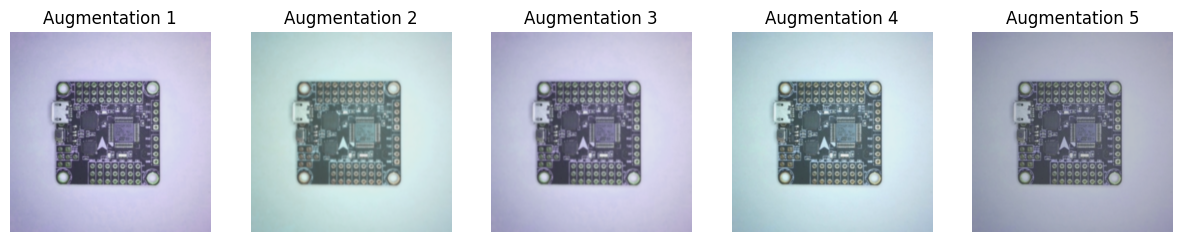

In [8]:
# Take a single training image and visualize augmentations
import matplotlib.pyplot as plt

sample_img = data_item.image[0]  # Get the first image in the batch

# Create a figure to display augmentations
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    # Apply augmentation (note: augmentations might return just the image if not designed for mask)
    # Some augmentations return (img, mask) tuple, others might return just img
    augmentation_result = augmentations(sample_img)
    
    # Handle both cases where augmentation returns tuple or just image
    if isinstance(augmentation_result, tuple):
        augmented_img = augmentation_result[0]
    else:
        augmented_img = augmentation_result
        
    # Visualize the augmented image
    axes[i].imshow(augmented_img.permute(1, 2, 0).cpu().numpy())
    axes[i].axis('off')
    axes[i].set_title(f'Augmentation {i+1}')
plt.show()

## Training the Model 🏃‍♂️‍➡️
- Callbacks are used to log metrics and model checkpoints during training. This allows for stopping training early if the model is not improving.
- Model checkpoints allow you to resume training from a specific point or to evaluate the model's performance at different stages.

<small>[Back to Top](#contents)</small>

In [9]:
from anomalib.models import Fastflow
from anomalib.engine import Engine
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from torchvision.transforms import v2


# Custom callback to log checkpoints to MLflow
import lightning.pytorch as pl
class MLflowCheckpointLogger(pl.callbacks.Callback):
    def on_save_checkpoint(self, trainer, pl_module, checkpoint):
        # log the train loss
        mlflow.log_metric("train_loss", trainer.callback_metrics["train_loss"].item())
        # logging.info("Saving checkpoint to MLflow")
        # # Find the last checkpoint path from ModelCheckpoint callback
        # for cb in trainer.callbacks:
        #     if isinstance(cb, ModelCheckpoint):
        #         ckpt_path = cb.last_model_path
        #         if ckpt_path and os.path.exists(ckpt_path):
        #             mlflow.log_artifact(ckpt_path)

model = Fastflow(
    # backbone="resnet18",  # or resnet50
    backbone="wide_resnet50_2",  # or resnet50
    pre_trained=True,
    evaluator=test_data_available  #if test_data_available (we found test directories), then we can evaluate performance in training
)

callbacks = [
    ModelCheckpoint(
        monitor="train_loss", 
        dirpath="checkpoints",
        filename="epoch_{epoch}_step_{step}",
        auto_insert_metric_name=False,
    ),
    EarlyStopping(
        monitor="train_loss",
        patience=3,
    ),
    MLflowCheckpointLogger(),
]

engine = Engine(
    callbacks=callbacks,
    logger=None,  # Disable AnomalibMLFlowLogger since there was a bug with artifact logging. We'll use MLflow directly
    accelerator="auto", 
    devices=1, 
    max_epochs=max_epochs,
)
mlflow.end_run() #in case there is a run already active 
mlflow_run = mlflow.start_run(tags={"model": "fastflow"}) 
mlflow.log_param("category", category)
mlflow.log_param("backbone", "resnet18")
mlflow.log_param("max_epochs", max_epochs)



c:\Github\MLOps-Precision-Lens\models\anomaly\.venv\Lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
2025-09-14 12:36:32,846 - anomalib.models.components.base.anomalib_module - INFO - Initializing Fastflow model.
2025-09-14 12:36:33,292 - timm.models._builder - INFO - Loading pretrained weights from Hugging Face hub (timm/wide_resnet50_2.racm_in1k)
2025-09-14 12:36:33,445 - timm.models._hub - INFO - [timm/wide_resnet50_2.racm_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
2025-09-14 12:36:33,481 - timm.models._builder - INFO - Missing keys (fc.weight, fc.bias) discovered while loading pretrained weights. This is expected if model is being adapted.


100

In [10]:
logging.info("Training the model")

engine.fit(
    model=model,
    datamodule=datamodule,
)

2025-09-14 12:36:33,758 - root - INFO - Training the model
INFO: GPU available: True (cuda), used: True
2025-09-14 12:36:33,797 - lightning.pytorch.utilities.rank_zero - INFO - GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
2025-09-14 12:36:33,799 - lightning.pytorch.utilities.rank_zero - INFO - TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
2025-09-14 12:36:33,800 - lightning.pytorch.utilities.rank_zero - INFO - HPU available: False, using: 0 HPUs
INFO: You are using a CUDA device ('NVIDIA GeForce RTX 5070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
2025-09-14 12:36:33,803 - lightning.pytorch.utilities.rank_zero - INFO - You are using a CUDA device (

Training: |          | 0/? [00:00<?, ?it/s]

c:\Github\MLOps-Precision-Lens\models\anomaly\.venv\Lib\site-packages\lightning\pytorch\core\module.py:520: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
c:\Github\MLOps-Precision-Lens\models\anomaly\.venv\Lib\site-packages\lightning\pytorch\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 3. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=100` reached.
2025-09-14 12:44:40,414 - lightning.pytorch.utilities.rank_zero - INFO - `Trainer.fit` stopped: `max_epochs=100` reached.
2025-09-14 12:44:40,633 - anomalib.callbacks.timer - INFO - Training took 486.71 seconds


In [11]:
logging.info("Evaluating model")

results = engine.validate(model=model, datamodule=datamodule)

metrics_dict = {}
if isinstance(results, list) and results and isinstance(results[0], dict):
    metrics_dict['image_AUROC'] = float(results[0].get('image_AUROC', float('nan')))
    metrics_dict['pixel_AUROC'] = float(results[0].get('pixel_AUROC', float('nan')))

if metrics_dict:
    logging.info(f"Skipping MLflow logging of metrics due to unique value constraint and conflict with log_model().")
    # logging.info(f"Logging metrics to MLflow: {metrics_dict}")
    # mlflow.log_metrics(metrics_dict)
else:
    logging.warning("No metrics found to log. Is the evaluator working properly?")

logging.info("Training and evaluation complete")


2025-09-14 12:44:40,646 - root - INFO - Evaluating model
INFO: The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: Evaluator, ImageVisualizer, PostProcessor, PreProcessor
2025-09-14 12:44:40,646 - lightning.pytorch.utilities.rank_zero - INFO - The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: Evaluator, ImageVisualizer, PostProcessor, PreProcessor
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2025-09-14 12:44:40,648 - lightning.pytorch.accelerators.cuda - INFO - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │            1.0            │
│        pixel_AUROC        │    0.9985054135322571     │
└───────────────────────────┴───────────────────────────┘

2025-09-14 12:44:40,872 - root - INFO - Skipping MLflow logging of metrics due to unique value constraint and conflict with log_model().
2025-09-14 12:44:40,873 - root - INFO - Training and evaluation complete


# Visualize a Single Prediction 🖼️

<small>[Back to Top](#contents)</small>

2025-09-14 12:44:40,886 - anomalib.engine.engine - WARNING - ckpt_path is not provided. Model weights will not be loaded.
INFO: The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: Evaluator, ImageVisualizer, PostProcessor, PreProcessor
2025-09-14 12:44:40,888 - lightning.pytorch.utilities.rank_zero - INFO - The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: Evaluator, ImageVisualizer, PostProcessor, PreProcessor
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2025-09-14 12:44:40,891 - lightning.pytorch.accelerators.cuda - INFO - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Github\MLOps-Precision-Lens\models\anomaly\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `

Predicting: |          | 0/? [00:00<?, ?it/s]

2025-09-14 12:44:41,025 - anomalib.visualization.image.item_visualizer - WARNING - Field 'gt_mask' is None in item. Skipping visualization.


Image Shape: torch.Size([1, 3, 256, 256]),
Anomaly Map Shape: torch.Size([1, 256, 256]), 
Predicted Mask Shape: torch.Size([1, 256, 256])
Image Shape: torch.Size([1, 3, 256, 256])
Image dims: 4


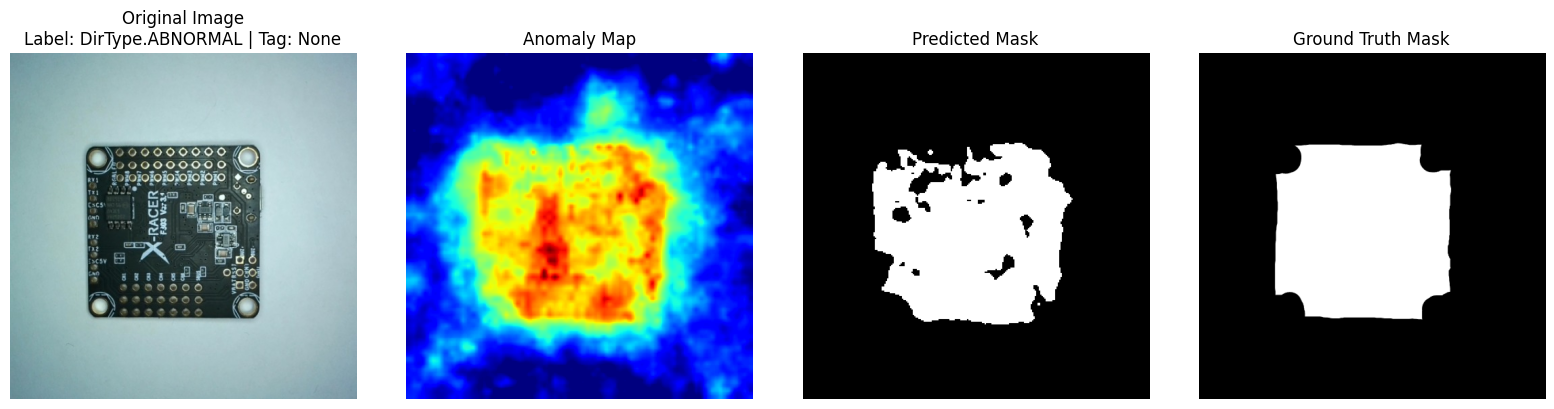

Path: C:\Github\MLOps-Precision-Lens\models\anomaly\s3cache\XRFC-PCB-Quality\test\anomaly\anomaly_1756348163.jpg
Pred Score: tensor([[1.]])


In [12]:
import matplotlib.pyplot as plt
from PIL import Image

# TODO: Implement batching, and create a plots for multiple sample.  These will be logged to MLflow with the model.

if test_data_available:
    test_samples = datamodule.test_data.samples
    random_sample = test_samples.sample(1)
    path = str(random_sample.iloc[0]["image_path"])
else:
    train_loader = datamodule.train_dataloader()
    random_sample = train_loader.dataset.samples.sample(1)
    path = str(random_sample.iloc[0]["image_path"])

predictions = engine.predict(model=model, data_path=path)  #You can also point to a folder with image or a single image instead of passing a dataset

def plot_results(data_sample):
    path = str(data_sample.iloc[0]["image_path"])


    original_img = Image.open(path)
    if test_data_available:
        mask = Image.open(str(random_sample.iloc[0]["mask_path"]))
    else:
        mask = Image.new("L", original_img.size, 0)

    # Extract the first prediction result
    pred = predictions[0]

    print(
        f'Image Shape: {pred.image.shape},\n'
        f'Anomaly Map Shape: {pred.anomaly_map.shape}, \n'
        f'Predicted Mask Shape: {pred.pred_mask.shape}',
    )

    # Extract label and tag from the sample DataFrame
    label = random_sample.iloc[0]["label"] if "label" in random_sample.columns else None
    tag = random_sample.iloc[0]["tag"] if "tag" in random_sample.columns else None

    # Create subplots for image, anomaly map, and predicted mask
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    img = pred.image
    print(f"Image Shape: {img.shape}")
    print(f"Image dims: {img.dim()}")
    if img.dim() == 4:
        # Batch of images, select the first one
        img = img[0]
    if img.dim() == 3:
        img = img.permute(1, 2, 0).cpu().numpy()  # reorders the dimensions of the tensor from `[C, H, W]` to `[H, W, C]`
    elif img.dim() == 2:
        img = img.cpu().numpy()
    else:
        raise ValueError(f"Unexpected image shape after batch selection: {img.shape}")

    anomaly_map = pred.anomaly_map
    if anomaly_map.dim() > 2:
        anomaly_map = anomaly_map[0]
    anomaly_map = anomaly_map.squeeze().cpu().numpy()

    pred_mask = pred.pred_mask
    if pred_mask.dim() > 2:
        pred_mask = pred_mask[0]
    pred_mask = pred_mask.squeeze().cpu().numpy()


    title_str = "Original Image"
    title_str += f"\nLabel: {label} | Tag: {tag}"

    axs[0].imshow(original_img)
    axs[0].set_title(title_str)
    axs[0].axis('off')
    axs[1].imshow(anomaly_map, cmap="jet")
    axs[1].set_title("Anomaly Map")
    axs[2].imshow(pred_mask, cmap="gray")
    axs[2].set_title("Predicted Mask")
    axs[3].imshow(mask, cmap="gray")
    axs[3].set_title("Ground Truth Mask")

    for ax in axs: ax.axis('off')
    plt.tight_layout()
    plt.show()
    print(f"Path: {path}")
    print(f"Pred Score: {pred.pred_score}")

    return fig

figure = plot_results(random_sample)
figure.savefig("fastflow_prediction.png")



## Predict and Visualize the Dataset 📅
We will use the trained FastFlow model to make predictions on the entire dataset and visualize the results using Voxel FiftyOne. With this interactive tool, we can explore the model's predictions, view the original images, and analyze the results.  The goal is to gain insights into the model's performance and identify any potential areas for improvement, both in the model and the dataset.

<small>[Back to Top](#contents)</small>

In [16]:
import fiftyone as fo
from fiftyone.core.expressions import ViewField as F
from fiftyone.core.labels import Classification, Segmentation
import numpy as np

images, class_names, labels, tags = s3data.get_dataset(bucket_name=bucket_name, prefix=category, limit=1000, cache_dir=cache_directory)
# Normalize all image paths to absolute paths for consistent lookup
def norm_path(p):
    return os.path.normcase(os.path.abspath(p))

dataset_dict_by_path = {
    norm_path(img): {
        "image": img,
        "class_name": class_names[i],
        "label": labels[i],
        "tags": tags[i]
    }
    for i, img in enumerate(images)
}

print("Sample ground truth labels:")
for i, (path, data) in enumerate(list(dataset_dict_by_path.items())[:50]):
    print(f"{i}: {path} → Label: {data['label']}")

print(f"Total images to process: {len(images)}")
# Create FO dataset from images, class_names, labels, and tags
name = "my-labelled-dataset"
if fo.dataset_exists(name):
    fo.delete_dataset(name)
dataset = fo.Dataset(name=name)

predictions = engine.predict(model=model, datamodule=datamodule)  # use the test data
#predictions = engine.predict(model=model, dataloaders=train_loader)  # use the training data 
print(f"Batches of predictions made: {len(predictions)}")
# flatten batches
predictions = [item for batch in predictions for item in batch]
print(f"Total predictions made: {len(predictions)}")


for i, pred in enumerate(predictions):

    ## Important prediction attributes:
    # image (Image)
    # anomaly_map (Mask)
    # pred_score (tensor([[0.09]]))
    # pred_mask (Mask)
    # pred_label (tensor[False]))
    # image_path (['C:/...'])

    anomaly_map = pred.anomaly_map
    pred_score = float(pred.pred_score) if hasattr(pred, 'pred_score') else None
    pred_mask = pred.pred_mask
    image_path = pred.image_path.item() if isinstance(pred.image_path, list) else pred.image_path
    pred_label = bool(pred.pred_label.item()) if hasattr(pred, 'pred_label') else None
    image = pred.image

    pred_mask = pred_mask.squeeze().cpu().numpy()

    norm_image_path = norm_path(image_path)
    tags = dataset_dict_by_path.get(norm_image_path, {}).get("tags", [])
    class_name = dataset_dict_by_path.get(norm_image_path, {}).get("class_name", "")
    label = dataset_dict_by_path.get(norm_image_path, {}).get("label", "")

    sample = fo.Sample(filepath=image_path, ground_truth=fo.Classification(label=label))

    if pred_score is not None:
        sample["pred_score"] = pred_score
    if pred_label is not None:
        sample["pred_label"] = pred_label
    if pred_mask is not None:
        sample["pred_mask"] = fo.Segmentation(mask=pred_mask.astype(np.uint8))

    dataset.add_sample(sample)

mismatches = dataset.match((F("pred_score") > 0.5) & (F("ground_truth.label") == "good"))
if len(mismatches) > 0:
    print(f"⚠️ Found {len(mismatches)} potential mismatches")
# View this instead: fo.launch_app(mismatches)

fo.launch_app(dataset)

Fetching dataset from S3 bucket: mvtechad
Downloaded: 0 Cached: 43 Ignored: 0

2025-09-14 12:47:21,141 - anomalib.engine.engine - WARNING - ckpt_path is not provided. Model weights will not be loaded.
INFO: The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: Evaluator, ImageVisualizer, PostProcessor, PreProcessor
2025-09-14 12:47:21,141 - lightning.pytorch.utilities.rank_zero - INFO - The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: Evaluator, ImageVisualizer, PostProcessor, PreProcessor
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2025-09-14 12:47:21,142 - lightning.pytorch.accelerators.cuda - INFO - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Sample ground truth labels:
0: c:\github\mlops-precision-lens\models\anomaly\s3cache\xrfc-pcb-quality\ground_truth\anomaly\anomaly_1755318100.png → Label: anomaly
1: c:\github\mlops-precision-lens\models\anomaly\s3cache\xrfc-pcb-quality\ground_truth\anomaly\anomaly_1756348129.png → Label: anomaly
2: c:\github\mlops-precision-lens\models\anomaly\s3cache\xrfc-pcb-quality\ground_truth\anomaly\anomaly_1756348163.png → Label: anomaly
3: c:\github\mlops-precision-lens\models\anomaly\s3cache\xrfc-pcb-quality\ground_truth\anomaly\anomaly_1756348180.png → Label: anomaly
4: c:\github\mlops-precision-lens\models\anomaly\s3cache\xrfc-pcb-quality\test\anomaly\anomaly_1755318100.jpg → Label: anomaly
5: c:\github\mlops-precision-lens\models\anomaly\s3cache\xrfc-pcb-quality\test\anomaly\anomaly_1756348129.jpg → Label: anomaly
6: c:\github\mlops-precision-lens\models\anomaly\s3cache\xrfc-pcb-quality\test\anomaly\anomaly_1756348163.jpg → Label: anomaly
7: c:\github\mlops-precision-lens\models\anomaly\s

Predicting: |          | 0/? [00:00<?, ?it/s]

Batches of predictions made: 1
Total predictions made: 6


Dataset:          my-labelled-dataset
Media type:       image
Num samples:      6
Selected samples: 0
Selected labels:  0
Session URL:      http://localhost:5151/

# 🕵️ Data Validation
The screenshot above is static screenshot created automatically by FiftyOne.  In a live notebook environment, you can manipulate filters, and inspect images and predictions interactively.  This is useful to ensure that the model is making accurate predictions and to identify any potential issues with the data or the model.

Future improvement could include versioning the dataset.

# Save the Model 💾
Log the model to MLFlow.  In the MLFlow UI we can promote the model to production, or set up automations to promote it automatically based on our collected metrics.

In [14]:
import mlflow

logging.info("Saving the model")

model_name = f"{category}_fastflow"
model_metrics = {}
if 'metrics_dict' in locals() and metrics_dict:
    if 'image_AUROC' in metrics_dict:
        model_metrics['image_AUROC'] = metrics_dict['image_AUROC']
    if 'pixel_AUROC' in metrics_dict:
        model_metrics['pixel_AUROC'] = metrics_dict['pixel_AUROC']

dataset_info = {
    "train_size": len(datamodule.train_data),
    "test_size": len(datamodule.test_data),
    "category": category,
    "bucket": bucket_name
}

# Log the prediction image as an artifact
if os.path.exists("fastflow_prediction.png"):
    mlflow.log_artifact("fastflow_prediction.png", "predictions")

logged_model = mlflow.pytorch.log_model(
    model,
    name=model_name, #artifact_path is depreciated
    metadata={
        'image_AUROC': model_metrics.get('image_AUROC'),
        'pixel_AUROC': model_metrics.get('pixel_AUROC'),
        'dataset_train_size': dataset_info.get('train_size'),
        'dataset_test_size': dataset_info.get('test_size'),
        'dataset_bucket_name': dataset_info.get('bucket'),
        'dataset_category': dataset_info.get('category')
    }
)

# Register the model in MLflow Model Registry
registered_model = mlflow.register_model(
    logged_model.model_uri,
    f"{category}_fastflow_model"
)


logging.info(f"Model and artifacts registered as: {registered_model.name} (Version: {registered_model.version})")

2025-09-14 12:45:04,449 - root - INFO - Saving the model
2025/09/14 12:45:05 WARNING mlflow.utils.requirements_utils: Found torch version (2.8.0+cu128) contains a local version label (+cu128). MLflow logged a pip requirement for this package as 'torch==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/09/14 12:45:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'XRFC-PCB-Quality_fastflow_model' already exists. Creating a new version of this model...
2025/09/14 12:45:31 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: XRFC-PCB-Quality_fastflow_model, version 5
Created version '5' of model 'XRFC-PCB-Quality_fastflow_model'.
2025-09-14 1

In [15]:
fo.close_app()
mlflow.end_run()

🏃 View run unleashed-deer-584 at: http://mlflow-mlflow/#/experiments/3/runs/e04aa23a23854856bbc778cdb590c69f
🧪 View experiment at: http://mlflow-mlflow/#/experiments/3


This is the end of the notebook. 👋